# Imports

In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten

# Predicting the mean, standard deviation of 2D Gaussian

## Using Neural Nets

In [77]:
def predict(model):
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000)
    
    # Apply the model to get predicted means and sigmas of the Gaussians
    
    pamp, pxmu, pxsig, pymu, pysig = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(511)
    _, _, _ = plt.hist(predy[:, 0] - pamp.flatten(), bins=30)
    plt.subplot(512)
    _, _, _ = plt.hist(predy[:, 1] - pxmu.flatten(), bins=30)
    plt.subplot(513)
    _, _, _ = plt.hist(predy[:, 2] - pxsig.flatten(), bins=30)
    plt.subplot(514)
    _, _, _ = plt.hist(predy[:, 3] - pymu.flatten(), bins=30)
    plt.subplot(515)
    _, _, _ = plt.hist(predy[:, 4] - pysig.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_amp = np.linspace(1., 10., 32) #one-to-one relation for amplitudes
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 4))
    
    # Plot the true y's and predicted y's from the NN model
    ax1.scatter(predy[:, 0], pamp.flatten(), marker='.')
    # Plot the 1-to-1 line
    ax1.plot(oto_amp, oto_amp, color='black', ls='--')
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('True value')
    ax1.set_title(r'Gaussian Amplitude')

    ax2.scatter(predy[:, 1], pxmu.flatten(), marker='.')
    ax2.plot(oto_means, oto_means, color='black', ls='--')
    ax2.set_xlabel('Predicted value')
    ax2.set_ylabel('True value')
    ax2.set_title(r'Gaussian x-$\mu$')
    
    ax3.scatter(predy[:, 2], pxsig.flatten(), marker='.')
    ax3.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax3.set_xlabel('Predicted value')
    ax3.set_ylabel('True value')
    ax3.set_title(r'Gaussian x-$\sigma$')
    
    ax4.scatter(predy[:, 3], pymu.flatten(), marker='.')
    ax4.plot(oto_means, oto_means, color='black', ls='--')
    ax4.set_xlabel('Predicted value')
    ax4.set_ylabel('True value')
    ax4.set_title(r'Gaussian y-$\mu$')
    
    ax5.scatter(predy[:, 4], pysig.flatten(), marker='.')
    ax5.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    ax5.set_xlabel('Predicted value')
    ax5.set_ylabel('True value')
    ax5.set_title(r'Gaussian y-$\sigma$')

    fig.show()

### Generate Gaussian given mu, sigma

In [78]:
# Calculate a 2d Gaussian given its mean and standard deviation
def gaussian2d(x_vals, y_vals, amp, x_mu, x_sigma, y_mu, y_sigma):
    return amp * np.exp(-0.5 * ( ((x_vals - x_mu)/x_sigma)**2 + ((y_vals - y_mu)/y_sigma)**2 ))

# Make array that describes Gaussian
def make_gaussians(num, amp_min=1., amp_max = 10.0, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0): 

    amp = np.random.uniform(amp_min, amp_max, num)
    
    x_mus = np.random.uniform(mu_min, mu_max, num)
    x_sigmas = np.random.uniform(sig_min, sig_max, num)
    
    y_mus = np.random.uniform(mu_min, mu_max, num)
    y_sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    y_vals = np.linspace(-10.0, 10.0, 32)
    
    x_grid, y_grid = np.meshgrid(x_vals, y_vals)
    
    models = np.zeros((num, 32, 32))
    #models = np.zeros((num, 32*32)) # flatten the Gaussian instead of keeping 2d array

    for i in range(num):
        #pdb.set_trace()
        models[i] = gaussian2d(x_grid, y_grid, amp[i], x_mus[i], x_sigmas[i], y_mus[i], y_sigmas[i])
        #models[i] = gaussian2d(x_grid, y_grid, amp[i], x_mus[i], x_sigmas[i], y_mus[i], y_sigmas[i]).flatten() # flatten the Gaussian instead of keeping 2d array
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((amp, x_mus, x_sigmas, y_mus, y_sigmas)).T

    return models, targets

In [79]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000):
    X_train, y_train = make_gaussians(n_train)
    X_test, y_test = make_gaussians(n_test)
    
    return X_train, y_train, X_test, y_test

### Create, compile, fit, and evaluate NN model

In [83]:
# Check out: https://datascience.stackexchange.com/questions/28003/get-multiple-output-from-keras
# for multi-output regression using Keras NNs

def evaluate_model(X_train, y_train, X_test, y_test):
    # Create model
    
    # Here, this means that our training set of 10000 samples will be divided into
    # 10000/batch_size = 10000/16 = 625 batches, each with 16 samples. The model
    # weights will be updated after each batch of 16.
    # One epoch will involve 625 batches, or 625 updates to the model
    # Since we are running 200 epochs, it will go through 200*625 batches = 125,000 batches
    # during the entire process
    verbose, epochs, batch_size = 1, 200, 16

    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    #input_shape = X_train.shape[1] # use when flatten the Gaussian instead of keeping 2d array
    #inputs = Input(shape=(input_shape,))

    x = Dense(10, activation='relu')(inputs)
    x = Dense(8, activation='relu')(x)
    x = Dense(5, activation='relu')(x)
    x = Flatten()(x)
    
    out1 = Dense(1, activation='linear', name='amplitude')(x)
    out2 = Dense(1, activation='linear', name='x_mean')(x)
    out3 = Dense(1, activation='linear', name='x_sigma')(x)
    out4 = Dense(1, activation='linear', name='y_mean')(x)
    out5 = Dense(1, activation='linear', name='y_sigma')(x)

    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[out1, out2, out3, out4, out5])
    #model.summary()
    model.compile(loss='mse', optimizer='rmsprop')#, metrics=['accuracy'])

    # Fit model
    model.fit(X_train, [y_train[:,0], y_train[:,1], y_train[:,2], y_train[:,3], y_train[:,4]], 
              epochs=epochs, verbose=verbose)
    
    # Run model on test set
    loss = model.evaluate(X_test, [y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3], y_test[:,4]], 
                          batch_size=batch_size, verbose=0)
    
    #print (model.metrics_names)
    predict(model)
    
    return loss

In [84]:
# If relevant, check accuracy of the model
def summarize_results(scores):
    #print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
    return

In [85]:
def detect_features(repeats=3):
    # Generate data
    X_train, y_train, X_test, y_test = generate_dataset()
    
    # Repeat experiment
    scores = list()
    
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        #pdb.set_trace()
        # **** score[0] below is currently the loss
        score = np.asarray(score[0]) #* 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
        
    # Summarize results
    #summarize_results(scores)
    
    return

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32)       0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 32, 10)       330         input_12[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 32, 8)        88          dense_34[0][0]                   
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 32, 5)        45          dense_35[0][0]                   
___________________________________________________________________________________________

10000/10000 [==============================] - 1s 78us/step - loss: 0.4847 - amplitude_loss: 0.3470 - x_mean_loss: 0.0592 - x_sigma_loss: 0.0532 - y_mean_loss: 0.0078 - y_sigma_loss: 0.0180
Epoch 30/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.4816 - amplitude_loss: 0.3453 - x_mean_loss: 0.0586 - x_sigma_loss: 0.0525 - y_mean_loss: 0.0075 - y_sigma_loss: 0.0182
Epoch 31/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.4781 - amplitude_loss: 0.3440 - x_mean_loss: 0.0575 - x_sigma_loss: 0.0522 - y_mean_loss: 0.0074 - y_sigma_loss: 0.0177
Epoch 32/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.4756 - amplitude_loss: 0.3417 - x_mean_loss: 0.0565 - x_sigma_loss: 0.0522 - y_mean_loss: 0.0073 - y_sigma_loss: 0.0175
Epoch 33/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.4721 - amplitude_loss: 0.3420 - x_mean_loss: 0.0557 - x_sigma_loss: 0.0502 - y_mean_loss: 0.0071 - y_sigma_loss: 0.017

10000/10000 [==============================] - 1s 77us/step - loss: 0.3943 - amplitude_loss: 0.3196 - x_mean_loss: 0.0176 - x_sigma_loss: 0.0381 - y_mean_loss: 0.0052 - y_sigma_loss: 0.0139
Epoch 70/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3923 - amplitude_loss: 0.3173 - x_mean_loss: 0.0178 - x_sigma_loss: 0.0380 - y_mean_loss: 0.0052 - y_sigma_loss: 0.0141
Epoch 71/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3931 - amplitude_loss: 0.3187 - x_mean_loss: 0.0176 - x_sigma_loss: 0.0378 - y_mean_loss: 0.0052 - y_sigma_loss: 0.0137
Epoch 72/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.3930 - amplitude_loss: 0.3190 - x_mean_loss: 0.0171 - x_sigma_loss: 0.0378 - y_mean_loss: 0.0050 - y_sigma_loss: 0.0139
Epoch 73/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3902 - amplitude_loss: 0.3161 - x_mean_loss: 0.0170 - x_sigma_loss: 0.0378 - y_mean_loss: 0.0051 - y_sigma_loss: 0.014

10000/10000 [==============================] - 1s 95us/step - loss: 0.3700 - amplitude_loss: 0.3048 - x_mean_loss: 0.0155 - x_sigma_loss: 0.0328 - y_mean_loss: 0.0044 - y_sigma_loss: 0.0126
Epoch 110/200
10000/10000 [==============================] - 1s 88us/step - loss: 0.3726 - amplitude_loss: 0.3076 - x_mean_loss: 0.0155 - x_sigma_loss: 0.0329 - y_mean_loss: 0.0044 - y_sigma_loss: 0.0127
Epoch 111/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.3705 - amplitude_loss: 0.3047 - x_mean_loss: 0.0159 - x_sigma_loss: 0.0327 - y_mean_loss: 0.0043 - y_sigma_loss: 0.0127
Epoch 112/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.3709 - amplitude_loss: 0.3050 - x_mean_loss: 0.0157 - x_sigma_loss: 0.0330 - y_mean_loss: 0.0044 - y_sigma_loss: 0.0131
Epoch 113/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3705 - amplitude_loss: 0.3057 - x_mean_loss: 0.0153 - x_sigma_loss: 0.0317 - y_mean_loss: 0.0043 - y_sigma_loss: 0

10000/10000 [==============================] - 1s 78us/step - loss: 0.3518 - amplitude_loss: 0.2908 - x_mean_loss: 0.0155 - x_sigma_loss: 0.0311 - y_mean_loss: 0.0037 - y_sigma_loss: 0.0105
Epoch 150/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.3527 - amplitude_loss: 0.2920 - x_mean_loss: 0.0154 - x_sigma_loss: 0.0311 - y_mean_loss: 0.0037 - y_sigma_loss: 0.0102
Epoch 151/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3522 - amplitude_loss: 0.2922 - x_mean_loss: 0.0156 - x_sigma_loss: 0.0309 - y_mean_loss: 0.0036 - y_sigma_loss: 0.0100
Epoch 152/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.3511 - amplitude_loss: 0.2913 - x_mean_loss: 0.0156 - x_sigma_loss: 0.0307 - y_mean_loss: 0.0037 - y_sigma_loss: 0.0099
Epoch 153/200
10000/10000 [==============================] - 1s 79us/step - loss: 0.3506 - amplitude_loss: 0.2890 - x_mean_loss: 0.0156 - x_sigma_loss: 0.0315 - y_mean_loss: 0.0036 - y_sigma_loss: 0

10000/10000 [==============================] - 1s 77us/step - loss: 0.3405 - amplitude_loss: 0.2808 - x_mean_loss: 0.0157 - x_sigma_loss: 0.0308 - y_mean_loss: 0.0033 - y_sigma_loss: 0.0096
Epoch 190/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3413 - amplitude_loss: 0.2804 - x_mean_loss: 0.0161 - x_sigma_loss: 0.0316 - y_mean_loss: 0.0032 - y_sigma_loss: 0.0100
Epoch 191/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3406 - amplitude_loss: 0.2808 - x_mean_loss: 0.0159 - x_sigma_loss: 0.0308 - y_mean_loss: 0.0032 - y_sigma_loss: 0.0098
Epoch 192/200
10000/10000 [==============================] - 1s 77us/step - loss: 0.3394 - amplitude_loss: 0.2790 - x_mean_loss: 0.0159 - x_sigma_loss: 0.0311 - y_mean_loss: 0.0033 - y_sigma_loss: 0.0102
Epoch 193/200
10000/10000 [==============================] - 1s 78us/step - loss: 0.3400 - amplitude_loss: 0.2806 - x_mean_loss: 0.0157 - x_sigma_loss: 0.0307 - y_mean_loss: 0.0032 - y_sigma_loss: 0

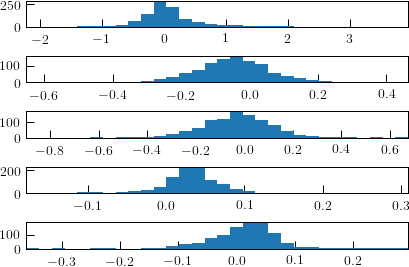

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


>#1: 0.286


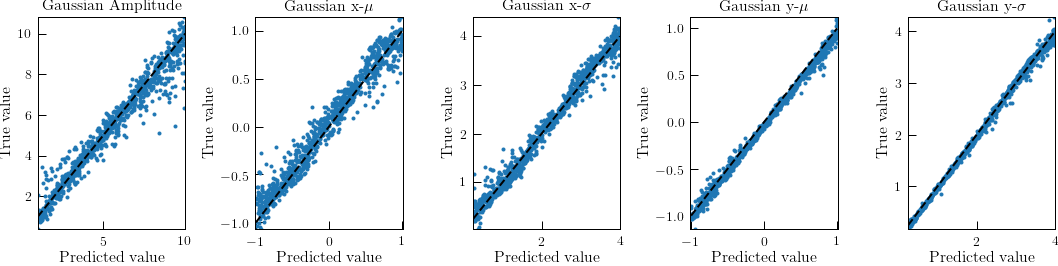

In [86]:
detect_features()


# Plot 2D Gaussian

In [87]:
# Import for 3d plotting
from mpl_toolkits import mplot3d

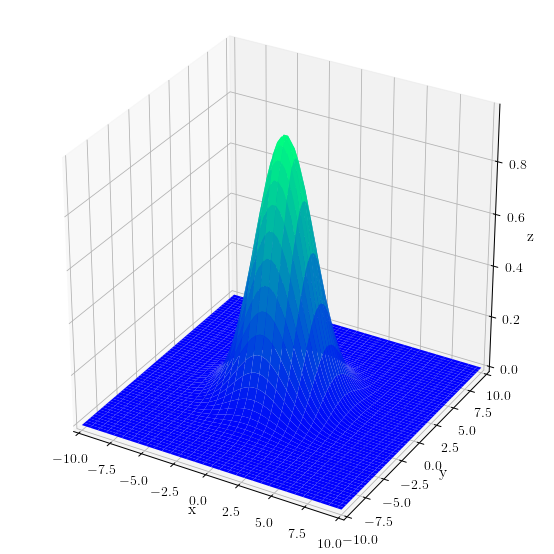

In [88]:
# Create x, y grid, and use it to generate a 2d Gaussian
x_vals = np.linspace(-10, 10, 64)
y_vals = np.linspace(-10, 10, 64)

x, y = np.meshgrid(x_vals, y_vals)

z = gaussian2d(x, y, 1, 0, 2, 0, 2)

# Plot 2d Gaussian
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, rstride=1, cstride=2, cmap='winter')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()